In [0]:
from __future__ import print_function
from PIL import Image
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.transforms as transforms
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
import torchvision 

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
transform_train1 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(hue=0.05, saturation= 0.05),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train2 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(hue=0.1, saturation= 0.1),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train3 = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [0]:
class NumpyImageDataset(data.Dataset):

# image dataset from numpy arrays

# Example:

  def __init__(self, data_array, label_array, transform=None, label_transform=None):

      self.data_tensor = data_array
      self.label_tensor = torch.from_numpy(label_array).type('torch.LongTensor')
      self.transform = transform
      self.label_transform = label_transform
      assert self.data_tensor.shape[0] == self.label_tensor.size(0)

  def __getitem__(self, index):
      img, label = self.data_tensor[index], self.label_tensor[index]

      # change to PIL image
      img = Image.fromarray(img)

      if self.transform is not None:
          # apply user-defined sequence of transformations
          img = self.transform(img)

      if self.label_transform is not None:
          label = self.label_transform(label)

      return img, label

  def __len__(self):
      return self.data_tensor.shape[0]
    
train_data = np.load('./cifar_train_data.npy').transpose((0,2,3,1))
train_label = np.load('./cifar_train_label.npy')
trainset1 = NumpyImageDataset(train_data[:45000], train_label[:45000], transform=transform_train1)
trainset2 = NumpyImageDataset(train_data[:45000], train_label[:45000], transform=transform_train2)
trainset = torch.utils.data.ConcatDataset([trainset1, trainset2])
trainloader = data.DataLoader(trainset, batch_size=250, shuffle=True, num_workers=4) 
testset = NumpyImageDataset(train_data[45000:50000], train_label[45000:50000],transform = transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=250, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


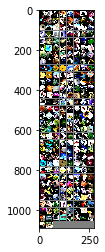

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        #self.dropout1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        #self.dropout2 = nn.Dropout(0.2)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=20):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        #self.dropout1 = nn.Dropout(0.2)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn1(self.conv2(out)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out    

def ResNet10():
    return ResNet(BasicBlock, [1,1,1,1],20) 

print("Let's use", torch.cuda.device_count(), "GPUs!")
net = ResNet10()
net = nn.DataParallel(net)

net.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tra

In [0]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1.4470312499999999e-05,betas=(0.95,0.98))
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [0]:
for epoch in range(15):  # loop over the dataset multiple times
    net.train()
    train_correct = 0.0
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        data=data.to(device)
        target=target.to(device)
        #print(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        pred = outputs.data.max(1)[1]  # get the index of the max log-probability
        train_correct += pred.eq(target.data).sum()
        if batch_idx % 40 == 39:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.5f Accuracy: %.1f' %
                  (epoch + 1, batch_idx + 1, running_loss / 10000.0,100.0*train_correct/10000.0)+'%')
            running_loss = 0.0
            train_correct = 0.0
    train_correct = 0.0
    scheduler.step()
    print("Current learning rate is", scheduler.get_lr())
    #net.eval()
    for batch_idx, (data, target) in enumerate(testloader):
        data = data.to(device)
        target = target.to(device)
        outputs = net(data)
        pred = outputs.data.max(1)[1]
        train_correct += pred.eq(target.data).sum()
    print('Test Accuracy: %.2f' %
                      (100.0*train_correct/len(testloader.dataset))+'%')
print('Finished Training')

[1,    40] loss: 0.00411 Accuracy: 67.0%
[1,    80] loss: 0.00408 Accuracy: 67.0%
[1,   120] loss: 0.00416 Accuracy: 67.0%
[1,   160] loss: 0.00414 Accuracy: 67.0%
[1,   200] loss: 0.00415 Accuracy: 67.0%
[1,   240] loss: 0.00421 Accuracy: 66.0%
[1,   280] loss: 0.00413 Accuracy: 67.0%
[1,   320] loss: 0.00408 Accuracy: 67.0%
[1,   360] loss: 0.00411 Accuracy: 67.0%
Current learning rate is [1.4470312499999999e-05]
Test Accuracy: 55.00%
[2,    40] loss: 0.00403 Accuracy: 68.0%
[2,    80] loss: 0.00404 Accuracy: 67.0%
[2,   120] loss: 0.00409 Accuracy: 67.0%
[2,   160] loss: 0.00411 Accuracy: 67.0%
[2,   200] loss: 0.00408 Accuracy: 68.0%
[2,   240] loss: 0.00409 Accuracy: 67.0%
[2,   280] loss: 0.00413 Accuracy: 67.0%
[2,   320] loss: 0.00421 Accuracy: 67.0%
[2,   360] loss: 0.00411 Accuracy: 66.0%
Current learning rate is [1.4470312499999999e-05]
Test Accuracy: 55.00%
[3,    40] loss: 0.00406 Accuracy: 67.0%
[3,    80] loss: 0.00409 Accuracy: 67.0%
[3,   120] loss: 0.00402 Accuracy: 6

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_data = np.load('./cifar_test_data.npy').transpose((0,2,3,1))
testset = NumpyImageDataset(test_data,np.zeros(10000),transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=0)
resultz=np.zeros(len(testloader.dataset))
index=0
for batch_idx, (data, target) in enumerate(testloader):
    data=data.to(device)
    target=target.to(device)
    outputs = net(data)
    #print(outputs)
    #print(outputs.data.max(1)[1])
    for i in range(50):
        resultz[batch_idx * 50+i] = outputs.data.max(1)[1][i] 

In [0]:
#print(outputs)
#print(outputs.data.max(1)[1])
np.save('./results2.npy',resultz)

In [0]:
import sys
# You can also import his python and call the following function
# to generate the submission file
def writeSubmissionFile(labels, fn):
    f = open(fn, 'w')
    f.write("id,category\n")
    for ii, ll in enumerate(labels):
        f.write(str(ii) + "," + str(int(ll)) + "\n")

    f.close()

In [0]:
writeSubmissionFile(np.load('./results2.npy'), './submit2.csv')